In [1]:
%reload_ext autoreload
%autoreload 2

In [269]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from neo.rawio import neuroscoperawio
from ripple_heterogeneity.utils import scalebars
import copy
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [193]:
basepath = r"Z:\Data\HMC1\day8"

st, cell_metrics = loading.load_spikes(
    basepath, brainRegion=["CA1","PFC","MEC"], putativeCellType="Pyr"
)
ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray(np.array([ripples.start,ripples.stop]).T).expand(0.2)

st, ripple_epochs

(<SpikeTrainArray at 0x19c6aa81a00: 258 units> at 20000 Hz,
 <EpochArray at 0x19c6aea1160: 6,641 epochs> of length 47:09:996 minutes)

In [194]:
ripples.iloc[3441]

start                     13465.3624
stop                      13465.4112
peaks                     13465.3936
amplitude                 720.597322
duration                      0.0488
frequency                 175.565915
peakNormedPower                  NaN
detectorName            bz_DetectSWR
ripple_channel                   294
event_spk_thres                    0
basepath           Z:\Data\HMC1\day8
basename                        day8
animal                          HMC1
Name: 3441, dtype: object

In [195]:
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

In [196]:
ca1_deep_idx = (cell_metrics.brainRegion.str.contains("CA1") & cell_metrics.deepSuperficial.str.contains("Deep")).values
ca1_sup_idx = (cell_metrics.brainRegion.str.contains("CA1") & cell_metrics.deepSuperficial.str.contains("Superficial")).values
pfc_idx = cell_metrics.brainRegion.str.contains("PFC").values
mec_idx = cell_metrics.brainRegion.str.contains("MEC").values


In [197]:
from xml.etree import ElementTree
def parse_xml_channel_groups(filename):
    filename = filename.replace('.xml', '').replace('.dat', '')

    tree = ElementTree.parse(filename + '.xml')
    root = tree.getroot()

    # find channels
    channel_group = []
    for grp_index, xml_chx in enumerate(
            root.find('anatomicalDescription').find('channelGroups').findall('group')):
        for xml_rc in xml_chx:
            channel_group.append([int(xml_rc.text),grp_index])
    return np.array(channel_group)

In [198]:
reader = neuroscoperawio.NeuroScopeRawIO('Z:/Data/HMC1/day8/day8')
reader.parse_header()
channel_group = parse_xml_channel_groups(reader.filename)
shank = 9
channel_indexes = channel_group[channel_group[:,1] == shank,0]

In [199]:
channel_indexes = [293,314,32,416]

In [200]:
# epoch of time around ripple, which was previously found
rip = 1
seconds_idx = np.array([ripple_epochs[rip].start,ripple_epochs[rip].stop])
# seconds_idx = np.array([7.320,7.620])

# convert to index
to_idx = (seconds_idx*reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(i_start=to_idx[0],
                                        i_stop=to_idx[1],
                                        channel_indexes=channel_indexes)

In [83]:
def plot_example_ripple(
    rip,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=-0.5
):
    group_colors = {
        "MEC": "#de2020",
        "PFC": "#116f70",
        "Deep": "#7b3294",
        "Superficial": "#008837",
    }

    seconds_idx = np.array([ripple_epochs[rip].start,ripple_epochs[rip].stop])
    # seconds_idx = np.array([7.320,7.620])

    # convert to index
    to_idx = (seconds_idx*reader.get_signal_sampling_rate()).astype(int)
    # get chunk of data
    raw_sigs = reader.get_analogsignal_chunk(i_start=to_idx[0],
                                            i_stop=to_idx[1],
                                            channel_indexes=channel_indexes)

    fig, axs = plt.subplots(
        4,
        1,
        figsize=functions.set_size("thesis", fraction=0.5, subplots=(2, 1)),
        sharex=True,
    )
    fig.subplots_adjust(hspace=hspace, wspace=0.1)
    axs = axs.ravel()
    ts = np.linspace(ripple_epochs[rip].start, ripple_epochs[rip].stop, raw_sigs.shape[0])
    # ts = np.arange(
    #     ripple_epochs[rip].start,
    #     ripple_epochs[rip].stop + 1 / reader.get_signal_sampling_rate(),
    #     1 / reader.get_signal_sampling_rate(),
    # )
    axs[0].plot(ts, raw_sigs[:, 0:2], color="k", linewidth=0.5)

    axs[1].plot(ts, raw_sigs[:, 2], color=group_colors["PFC"], linewidth=0.5)

    axs[2].plot(ts, raw_sigs[:, 3], color=group_colors["MEC"], linewidth=0.5)

    npl.rasterplot(
        st.iloc[:, ca1_sup_idx][ripple_epochs[rip]],
        lw=1,
        lh=7,
        ax=axs[3],
        color=group_colors["Superficial"],
        vertstack=True,
    )
    npl.rasterplot(
        st.iloc[:, ca1_deep_idx][ripple_epochs[rip]],
        lw=1,
        lh=7,
        ax=axs[3],
        color=group_colors["Deep"],
        vertstack=True,
    )
    npl.rasterplot(
        st.iloc[:, pfc_idx][ripple_epochs[rip]],
        lw=1,
        lh=7,
        ax=axs[3],
        color=group_colors["PFC"],
        vertstack=True,
    )
    npl.rasterplot(
        st.iloc[:, mec_idx][ripple_epochs[rip]],
        lw=1,
        lh=7,
        ax=axs[3],
        color=group_colors["MEC"],
        vertstack=True,
    )

    axs[0].get_shared_y_axes().join(axs[0], *axs[:-1])
    axs[0].axes.get_yaxis().set_visible(False)
    axs[1].axes.get_yaxis().set_visible(False)
    axs[2].axes.get_yaxis().set_visible(False)

    axs[0].set_axis_off()
    axs[1].set_axis_off()
    axs[2].set_axis_off()

    axs[0].set_facecolor("none")
    axs[1].set_facecolor("none")
    axs[2].set_facecolor("none")
    axs[3].set_facecolor("none")


    axs[3].axes.get_yaxis().set_visible(False)

    ymin, ymax = axs[3].axes.get_ylim()
    axs[3].set_ylim(ymin-1, ymax+1)

    # axs[0].get_yaxis().set_visible(False)
    sns.despine(left=True)
    axs[3].set_xlabel("time (sec)")


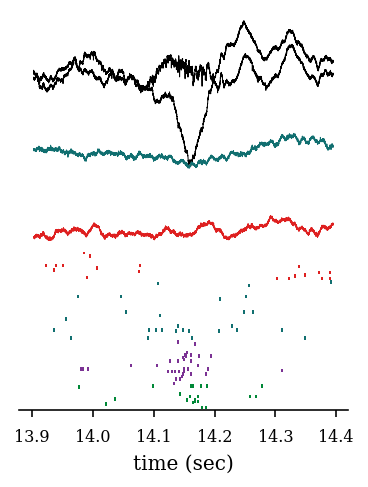

In [111]:
plot_example_ripple(
    1,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader
)
plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example.svg"),
    dpi=300,
    bbox_inches="tight",
)

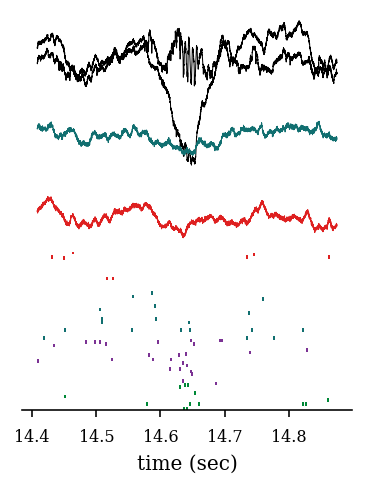

In [156]:
plot_example_ripple(
    2,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader
)
plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example_1.svg"),
    dpi=300,
    bbox_inches="tight",
)

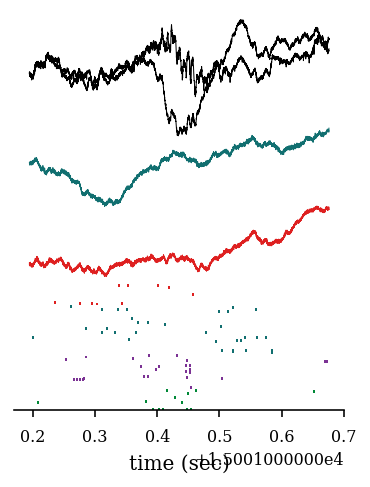

In [157]:
plot_example_ripple(
    4002,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=-0.3
)
plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example_2.svg"),
    dpi=300,
    bbox_inches="tight",
)

## many deep and pfc response

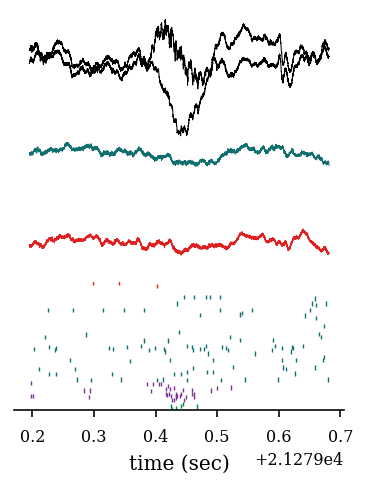

In [70]:
plot_example_ripple(
    5888,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=-0.3
)
plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example_5888.svg"),
    dpi=300,
    bbox_inches="tight",
)

## many sup and mec cells

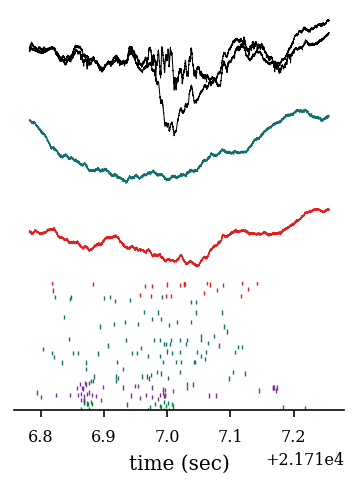

In [72]:
plot_example_ripple(
    6043,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=-0.3
)

plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example_6043.svg"),
    dpi=300,
    bbox_inches="tight",
)

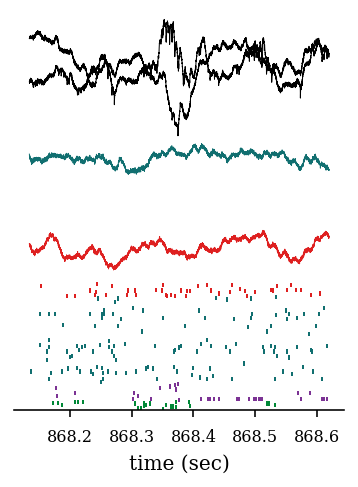

In [84]:
plot_example_ripple(
    309,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=-0.3
)


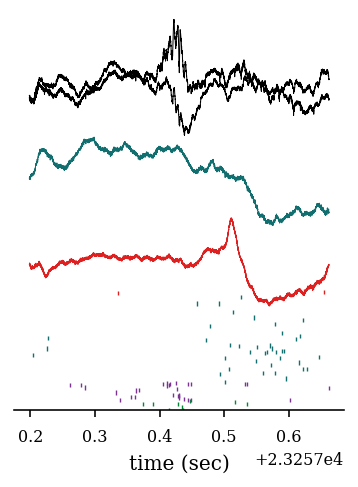

In [77]:
plot_example_ripple(
    6585,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=-0.3
)
plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example_6585.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [272]:
def plot_example_ripple(
    rip,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=-0.5,
    reorder=False
):
    group_colors = {
        "MEC": "#de2020",
        "PFC": "#116f70",
        "Deep": "#7b3294",
        "Superficial": "#008837",
    }

    seconds_idx = np.array([ripple_epochs[rip].start,ripple_epochs[rip].stop])

    # convert to index
    to_idx = (seconds_idx*reader.get_signal_sampling_rate()).astype(int)
    # get chunk of data
    raw_sigs = reader.get_analogsignal_chunk(i_start=to_idx[0],
                                            i_stop=to_idx[1],
                                            channel_indexes=channel_indexes)

    fig, axs = plt.subplots(
        2,
        1,
        figsize=functions.set_size("thesis", fraction=0.5, subplots=(2, 1)),
        sharex=True,
    )
    fig.subplots_adjust(hspace=hspace, wspace=0.1)
    axs = axs.ravel()
    ts = np.linspace(ripple_epochs[rip].start, ripple_epochs[rip].stop, raw_sigs.shape[0])

    axs[0].plot(ts, raw_sigs[:, 0]+1000, color="k", linewidth=0.25)
    axs[0].plot(ts, raw_sigs[:, 1]-1000, color="k", linewidth=0.25)

    if reorder:
        neworder = st.iloc[:, ca1_sup_idx][ripple_epochs[rip]].get_event_firing_order()
        curr_st = copy.deepcopy(st.iloc[:, ca1_sup_idx][ripple_epochs[rip]].reorder_series_by_ids(neworder))
    else:
        curr_st = copy.deepcopy(st.iloc[:, ca1_sup_idx][ripple_epochs[rip]])
    npl.rasterplot(
        curr_st,
        lw=1,
        lh=7,
        ax=axs[1],
        color=group_colors["Superficial"],
        vertstack=True,
    )
    if reorder:
        neworder = st.iloc[:, ca1_deep_idx][ripple_epochs[rip]].get_event_firing_order()
        curr_st = copy.deepcopy(st.iloc[:, ca1_deep_idx][ripple_epochs[rip]].reorder_series_by_ids(neworder))
    else:
        curr_st = copy.deepcopy(st.iloc[:, ca1_deep_idx][ripple_epochs[rip]])
    npl.rasterplot(
        curr_st,
        lw=1,
        lh=7,
        ax=axs[1],
        color=group_colors["Deep"],
        vertstack=True,
    )
    if reorder:
        neworder = st.iloc[:, pfc_idx][ripple_epochs[rip]].get_event_firing_order()
        curr_st = copy.deepcopy(st.iloc[:, pfc_idx][ripple_epochs[rip]].reorder_series_by_ids(neworder))
    else:
        curr_st = copy.deepcopy(st.iloc[:, pfc_idx][ripple_epochs[rip]])
    npl.rasterplot(
        curr_st,
        lw=1,
        lh=7,
        ax=axs[1],
        color=group_colors["PFC"],
        vertstack=True,
    )
    if reorder:
        neworder = st.iloc[:, mec_idx][ripple_epochs[rip]].get_event_firing_order()
        curr_st = copy.deepcopy(st.iloc[:, mec_idx][ripple_epochs[rip]].reorder_series_by_ids(neworder))
    else:
        curr_st = copy.deepcopy(st.iloc[:, mec_idx][ripple_epochs[rip]])
    npl.rasterplot(
        curr_st,
        lw=1,
        lh=7,
        ax=axs[1],
        color=group_colors["MEC"],
        vertstack=True,
        labels="MEC"
    )

    axs[0].get_shared_y_axes().join(axs[0], *axs[:-1])
    axs[0].axes.get_yaxis().set_visible(False)
    axs[1].axes.get_yaxis().set_visible(False)
    # axs[2].axes.get_yaxis().set_visible(False)

    axs[0].set_axis_off()
    # axs[1].set_axis_off()
    # axs[2].set_axis_off()

    axs[0].set_facecolor("none")
    # axs[1].set_facecolor("none")
    # axs[2].set_facecolor("none")
    axs[1].set_facecolor("none")


    axs[1].axes.get_yaxis().set_visible(False)

    ymin, ymax = axs[1].axes.get_ylim()
    axs[1].set_ylim(ymin-1, ymax+1)

    xmin, xmax = axs[1].axes.get_xlim()

    axs[1].set_xticks(np.arange(xmin, xmax,.1))
    # axs[1].set_xlabels([‘two’, ‘four’,’six’, ‘eight’, ‘ten’])
    scalebars.add_scalebar(axs[1],labelx="100ms", sizex=.1,matchx=False, matchy=False, hidex=True, hidey=True,pad=-1,loc=3)
    # axs[0].get_yaxis().set_visible(False)
    # sns.despine(left=True)
    # axs[1].set_xlabel("time (sec)")
    axs[1].set_ylabel("Pyr Units")
    return axs

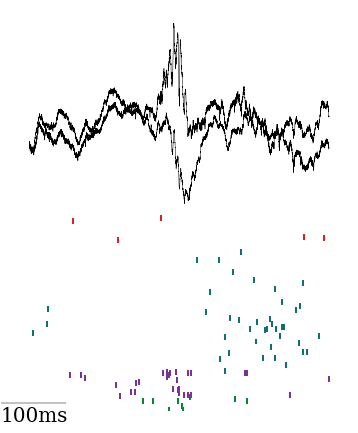

In [191]:
axs = plot_example_ripple(
    6585,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=0
)
plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example_6585.svg"),
    dpi=300,
    bbox_inches="tight",
)

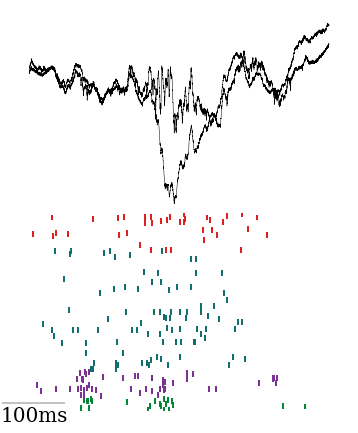

In [207]:
axs = plot_example_ripple(
    6043,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=0
)
plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example_6043.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [235]:
basepath = r"Z:\Data\HMC1\day13"

st, cell_metrics = loading.load_spikes(
    basepath, brainRegion=["CA1","PFC","MEC"], putativeCellType="Pyr"
)
ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray(np.array([ripples.start,ripples.stop]).T).expand(0.2)

cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

ca1_deep_idx = (cell_metrics.brainRegion.str.contains("CA1") & cell_metrics.deepSuperficial.str.contains("Deep")).values
ca1_sup_idx = (cell_metrics.brainRegion.str.contains("CA1") & cell_metrics.deepSuperficial.str.contains("Superficial")).values
pfc_idx = cell_metrics.brainRegion.str.contains("PFC").values
mec_idx = cell_metrics.brainRegion.str.contains("MEC").values

reader = neuroscoperawio.NeuroScopeRawIO('Z:/Data/HMC1/day13/day13')
reader.parse_header()
channel_group = parse_xml_channel_groups(reader.filename)
shank = 9
channel_indexes = channel_group[channel_group[:,1] == shank,0]

channel_indexes = [257,280,32,416]


In [232]:
ripples.iloc[3535]

index                            3536
start                      13037.8688
stop                        13037.948
peaks                      13037.9256
amplitude                 1083.960225
duration                       0.0792
frequency                  171.837449
peakNormedPower                   NaN
detectorName             bz_DetectSWR
ripple_channel                    378
event_spk_thres                     0
basepath           Z:\Data\HMC1\day13
basename                        day13
animal                           HMC1
Name: 3535, dtype: object

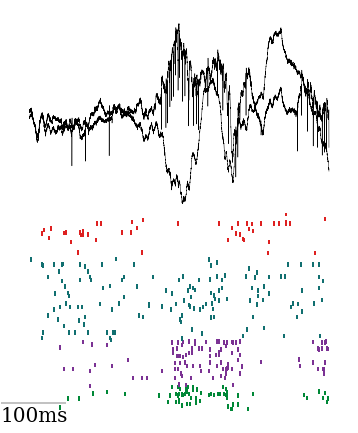

In [236]:


axs = plot_example_ripple(
    3534,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=0
)

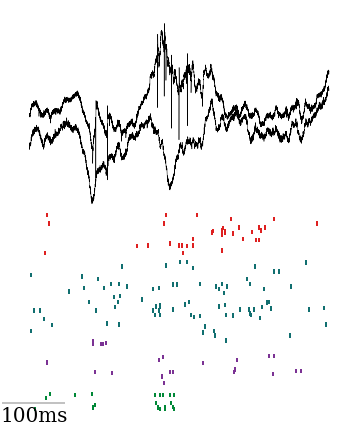

In [246]:
5546
axs = plot_example_ripple(
    5546-2,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=0
)

plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example_5546.svg"),
    dpi=300,
    bbox_inches="tight",
)

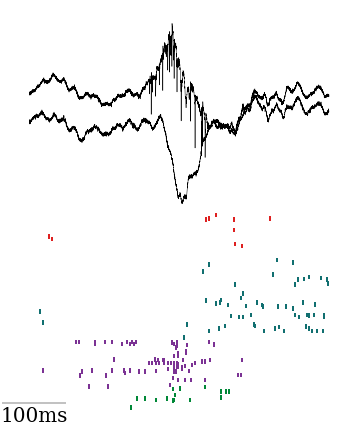

In [250]:
2208
axs = plot_example_ripple(
    2208-1,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=0
)
plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example_2208.svg"),
    dpi=300,
    bbox_inches="tight",
)

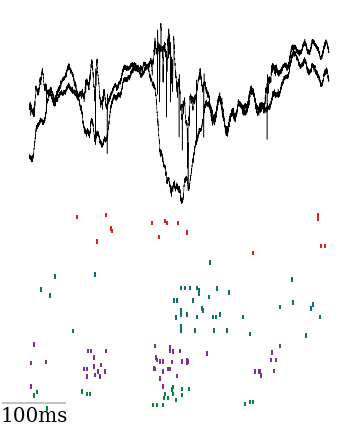

In [251]:
2216
axs = plot_example_ripple(
    2216-1,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=0
)

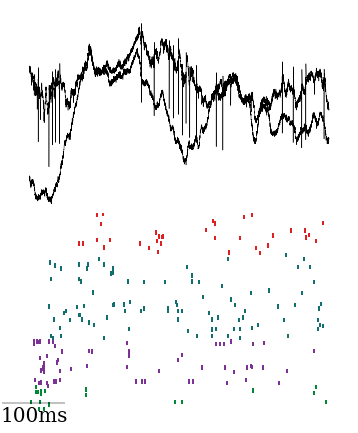

In [277]:
axs = plot_example_ripple(
    6661-2,
    raw_sigs,
    ripple_epochs,
    ca1_sup_idx,
    ca1_deep_idx,
    pfc_idx,
    mec_idx,
    reader,
    hspace=0
)